In [2]:
import pandas as pd
import numpy as np
from numpy import vstack, mean, std
import h5py
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics 
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import Tensor 
from torch.nn import Linear, Sigmoid, Module, BCELoss 
from torch.optim import SGD
from preprocessing import preprocess
from get_symbol import get_symbol
from prediction_pipeline import *

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load and prepare data

In [13]:
def load_data(expression_path, libraries, gr_truth_path): 
    norm = get_expression_data(expression_path)
    binary_matrix = get_binary_matrix(norm.index, libraries)
    gr_truth = get_gr_truth(norm.columns, gr_truth_path)
    return norm, binary_matrix, gr_truth

def get_expression_data(expression_path): 
    f = pd.read_csv(expression_path)
    f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
    f = f.iloc[:, 1:] # Remove first index column 
    # Normalize data 
    norm = preprocess(f)
    # Convert Ensembl number index to gene symbol
    norm = get_symbol(norm)
    return norm 

def get_binary_matrix(gene_expr, libraries):
    function_to_genes = {}
    set_genes = set()
    for lib in libraries: 
        f2g, genes = gene_set_dictionaries(lib)
        function_to_genes.update(f2g)
        set_genes = set_genes | set(genes)
    common_genes = list(set_genes & set(gene_expr))
    binary_matrix = gs_binary_matrix(function_to_genes, set_genes).loc[common_genes]
    return binary_matrix

def get_gr_truth(list_samples, gr_truth_path):
    gr_truth = pd.read_csv(gr_truth_path, sep='\t')
    gr_truth = gr_truth.iloc[10, 1:]
    idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
    gr_truth.index = idx
    gr_truth = pd.DataFrame(gr_truth).loc[list_samples]
    test = [ 1.0 if res[-3:] == 'POS' else 0.0 for res in gr_truth.iloc[:, 0] ]
    gr_truth.iloc[:, 0] = test
    gr_truth.columns = ["Truth"]
    return gr_truth

def prepare_data(norm, binary_matrix, gr_truth):
    # load the dataset
    list_inputs = []
    common_genes = set(binary_matrix.index) & set(norm.index)
    bm = binary_matrix.loc[common_genes]
    bm_tens = torch.tensor(bm.T.values)
    for sample in norm.columns: 
        item = torch.mul(bm_tens, torch.tensor(norm.loc[common_genes, sample].values))
        list_inputs.append(np.array(item).astype(np.float32))
    dataset = CSVDataset(list_inputs, gr_truth) 
    # calculate split 
    train, test = dataset.get_splits()
    # prepare data loaders 
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=32, shuffle=False)
    return train_dl, test_dl
    
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, expr_by_path, gr_truth): 
        # store the inputs and outputs 
        self.X = expr_by_path
        self.y = np.array(gr_truth)
        # ensure input data is floats 
        self.y = self.y.astype('float32').reshape((len(self.y), 1))
        
    # number of rows in dataset 
    def __len__(self): 
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33): 
        # determine sizes 
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate split
        return random_split(self, [train_size, test_size])
    
# model definition
class MLP(Module): 
    # define model elements 
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer 
        self.hidden = Linear(n_inputs, 1)
        # output
        self.act = Sigmoid()
    
    # forward propagate input 
    def forward(self, X): 
        # input to first hidden layer 
        X = self.hidden(X) 
        # output 
        X = self.act(X)
        return X
    
# train the model
def train_model(train_dl, model):
    # define optimization
    criterion = BCELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs 
    for epoch in range(100):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl): 
            # clear the gradients 
            optimizer.zero_grad()
            # compute model output  
            yhat = model(inputs)
            # calculate loss 
#             loss = criterion(yhat, targets)
            # credit assignment
#             loss.backward()
            # update model weights 
#             optimizer.step()

# evaluate model 
def evaluate_model(test_dl, model):
    # generate no skill prediction
    y = [0]*1000
    ns_probs = [0 for n in y]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', color='black')
    predictions, actuals = [], []
    outer_results = []
    summary = [] # how do we get model's parameters?
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate model on test set
        yhat = model(inputs)
        # retrieve numpy array 
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values 
        yhat = yhat.round()
        predictions.append(yhat)
        actuals.append(actual)
        # auroc
        fpr, tpr, _ = roc_curve(yhat, actual)
        auc_ = metrics.auc(fpr, tpr)
        outer_results.append(auc_)
        plt.plot(fpr, tpr, marker='.')
        print(auc_)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    print('AUC: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the plot
    plt.show()

# make class prediction for one row of data 
def predict(row, model):
    # convert row to data 
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array 
    yhat = yhat.detach().numpy()
    return yhat

In [4]:
# load the data 
expression_path = 'GSE156063_swab_gene_counts.csv.gz'
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']
gr_truth_path = "GSE156063_series_matrix.txt"
norm, binary_matrix, gr_truth = load_data(expression_path, libraries, gr_truth_path) 

In [5]:
train_dl, test_dl = prepare_data(norm, binary_matrix, gr_truth)

In [6]:
print(len(train_dl.dataset), len(test_dl.dataset))

157 77


In [14]:
common_genes = set(norm.index) & set(binary_matrix.index)
# define the network
model = MLP(len(common_genes))

In [15]:
# train the model
train_model(train_dl, model)

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


ValueError: unknown format is not supported

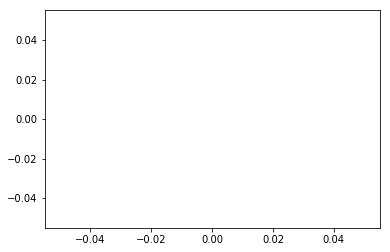

In [17]:
# evaluate model
evaluate_model(test_dl, model)

In [ ]:
criterion = BCELoss()
for i, (inputs, targets) in enumerate(test_dl): 
    yhat = model(inputs)
    t = targets 
    print(yhat)
    print(t)

tensor([[[0.4874],
         [0.5657],
         [0.4912],
         ...,
         [0.6199],
         [0.6887],
         [0.5088]],

        [[0.4829],
         [0.5724],
         [0.4865],
         ...,
         [0.6151],
         [0.6793],
         [0.5117]],

        [[0.4877],
         [0.5606],
         [0.4942],
         ...,
         [0.6219],
         [0.6913],
         [0.5105]],

        ...,

        [[0.4892],
         [0.5505],
         [0.4927],
         ...,
         [0.6238],
         [0.6815],
         [0.5084]],

        [[0.4896],
         [0.5509],
         [0.4966],
         ...,
         [0.6227],
         [0.6873],
         [0.5101]],

        [[0.4938],
         [0.5474],
         [0.4869],
         ...,
         [0.6151],
         [0.6821],
         [0.5102]]], grad_fn=<SigmoidBackward>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.

In [174]:
common_genes = set(binary_matrix.index) & set(norm.index)
bm = binary_matrix.loc[common_genes]
bm_tens = torch.tensor(bm.T.values)
bm_tens.shape

torch.Size([6700, 12639])

In [182]:
y = torch.tensor(norm.loc[common_genes].iloc[:,0].values)
y.shape

torch.Size([12639])

In [183]:
torch.mul(bm_tens, y).shape

torch.Size([6700, 12639])

# Neural network